<a href="https://colab.research.google.com/github/patricksabry/UTS_ML2019_ID98106545/blob/master/A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scalable Recommendation System using Spark (PySpark)

# Introduction

In the current age of information recommendation systems are a cornerstone of majority of our online interactions with products and social networks. Hyper consumption of media and consumer products online has seen machine learning powered recommendation systems rise to prominence on platforms such as Amazon, Facebook and Netflix. By leveraging behavioral data and supervised machine learning, internet users are being served tailored, personalised experiences when shopping and consuming online media. The widespread acknowledgment of the utilitarian value-add that recommendation systems provide has led to mercurial advancements in scalable compute frameworks and parallelized machine learning techniques. One of the most notable of these is Spark and Spark MLlib, a fast and scalable unified analytics engine for big data processing and machine learning.

The following notebook outlines the implementation of a content based recommendation system using Apache Spark. Spark will be used for scalable parallel memory-based data processing. This will ensure that this algorithm implementation is highly scalable based on how large of a compute cluster it is run on. Spark's ML library will be accessed via PySpark, Spark's high level Python API, and the dataset used for the recommendation system will be the open sourced MovieLens dataset. Movies will be recommended based on collaborative filtering using an Alternate Least Squares algorithm to find similar user ratings for certain movies.

$\hat{r}$ = $\sum_{f=0}^{n factors}$ $H_{u,f}$$W_{f,i}$

Whereby for any item $i$ given by user $u$ the rating of the item can be expressed as a matrix dot ptoduct of the user latent vector $H$ and the item latent vector $W$.



# Social and Ethical Implications of recommendation systems

Utilitarian ethics suggests that the actions of an agent or system should be taken in the best interest of happiness and wellbeing. An ethical framework predicated on virtuous value maximization is befittingly adopted when developing this recommendation system. Recommendation systems serve to create value for users of a system by intelligently suggesting items such as products or movies to a user based on the historical interactions of similar users with the system. It is plausible to suggest that the utility afforded by the recommendation system to the users outweighs the privacy concerns of collection and manipulation of behavioral user data.

In the context of this particular system, the dataset used for training the model is open sourced for academic use, abolishing concerns of privacy exploitation. When collecting and cleaning behavioral user data I believe it is imperative to clearly communicate the intention of data use with the users and model the data in a meaningful way to mutually benefit the user and the platform in question. This can be communicated through end user license agreements and terms of use, which is evident on platforms such as Amazon and Netflix.

Misplaced trust of users in a given platform's privacy policies can have detrimental social and ethical implications. This was highlighted in the Cambridge Analytica Facebook scandal, whereby personal user data was wrongfully collected and used to engineer a politically biased advertisement recommendation campaign which was used to push a political agenda. This misuse of data ultimately resulted in Facebook incurring a $5 billion fine in July 2019.

Evidently, intentionally malicious misuse of user data in building a recommendation system such as in this project should be avoided at all costs.

# Data Exploration and Pre-processing

This ALS algorithm implementation will leverage the distributed processing power of spark through the use of Resilient Distributed Datasets (RDD). The Apache foundation defines an RDD as an immutable distributed collection of objects. Each dataset is divided into logical partitions, which may be computed on different nodes of the cluster. This implementation is highly scalable and boasts data read speeds of up to 100x faster than Hadoop MapReduce.

In order to pre-process the MovieLens data it must first be imported and transformed into a spark dataframe. The dataset is comprised of two independent files 'movies.csv' and 'ratings.csv' which are hosted on this project's GitHub repository.



In [138]:
import pandas as pd
pd.set_option('display.max_columns', None)  

movies_url = 'https://raw.githubusercontent.com/patricksabry/UTS_ML2019_ID98106545/master/movies.csv'
ratings_url = 'https://raw.githubusercontent.com/patricksabry/UTS_ML2019_ID98106545/master/ratings.csv'
df_movies = pd.read_csv(movies_url)
df_ratings = pd.read_csv(ratings_url)

print(df_movies.head())
print(df_ratings.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


The movies and ratings dataframes must be represented as an RDD of triplets in the following format:

Ratings : RDD(($u$, $i$, $r_{ui}$), . . .)

With each row consisting of a rating $r_{ui}$ given to item $i$ by user $u$


In [139]:
df = pd.merge(df_ratings, df_movies, on='movieId')
print(df.head())
df.shape


   userId  movieId  rating   timestamp             title  \
0       1        1     4.0   964982703  Toy Story (1995)   
1       5        1     4.0   847434962  Toy Story (1995)   
2       7        1     4.5  1106635946  Toy Story (1995)   
3      15        1     2.5  1510577970  Toy Story (1995)   
4      17        1     4.5  1305696483  Toy Story (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1  Adventure|Animation|Children|Comedy|Fantasy  
2  Adventure|Animation|Children|Comedy|Fantasy  
3  Adventure|Animation|Children|Comedy|Fantasy  
4  Adventure|Animation|Children|Comedy|Fantasy  


(100836, 6)

In [140]:
num_ratings = df.rating.count()
num_movies = df['movieId'].nunique()
num_users = df['userId'].nunique()

print("Observed " + str(num_ratings) + " ratings from " + str(num_users) + " users on " + str(num_movies) + " movies")

Observed 100836 ratings from 610 users on 9724 movies


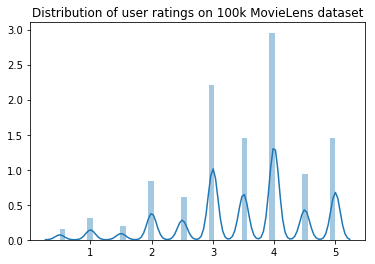

In [141]:
import matplotlib.pyplot as plt
import seaborn as sns

x = df['rating'].values
sns.distplot(x)
plt.title("Distribution of user ratings on 100k MovieLens dataset")
plt.show()

## Downloading Spark dependencies & initializing enviornment


In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
# Set java sdk and Spark enviornment paths
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

# Use PySpark to intialise spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()

# Implementation Methodology

The system will strive to learn latent factors by minimising an error measure in respect to an Alternate Least Squares algorithm which will be fitted on the pre-processed data.

In [148]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.types import FloatType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from pyspark.sql import SQLContext

# Convert Pandas dataframe to Spark RDD based dataframe
spark_df = sc.createDataFrame(df)
spark_df_movies = sc.createDataFrame(df_movies)

# Split the input data into train, validation and test datasets 
X_train, X_val = spark_df.randomSplit([0.7,0.3])

# Define gridsearch parameters to apply to the ALS model
# Note: As this application of ALS is explicit, the alpha parameter is ignored
maxIters = [5,8,10]
ranks = [4,6,8,10,12]
regularization_vals = [0.01,0.1,1]

best_iteration = -1
best_rank = -1
best_reg_val = -1
min_error = float('inf')

# Fit ALS model on all possible combinations of parameters to determine optimal parameters
start = time.time()
for maxIter in maxIters:
    for rank in ranks:
        for regVal in regularization_vals:
            als = ALS(maxIter=maxIter, regParam=regVal, rank=rank, userCol="userId", 
                      itemCol="movieId", ratingCol="rating", coldStartStrategy="drop" )
            model = als.fit(X_train)
            # Evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(X_val)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)            
            if rmse < min_error:
                min_error = rmse
                best_iteration = maxIter
                best_rank = rank
                best_reg_val = regVal
end = time.time()
gridsearch_time = (end - start)

print("Best model achieved an RMSE of " + str(round(min_error,4)) + " with parameters [" + "maxIter: " + str(best_iteration) + " ranks: " + str(best_rank) + " regParam: " + str(best_reg_val) + "]")
print("Gridsearching " + str(len(maxIters)*len(ranks)*len(regularization_vals)) + " possible param combinations took " + str(gridsearch_time) + "seconds")            
            
                 
            
# # Build the recommendation model using distributed ALS on the training data
# als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
# model = als.fit(X_train)

# # Evaluate the model by computing the RMSE on the validation data
# predictions = model.transform(X_test)
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
#                                 predictionCol="prediction")
# rmse = evaluator.evaluate(predictions)
# print("RMSE = " + str(rmse))

# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)

# userRecs.show(10,False)
# movieRecs.show(10,False)

# sc.stop()

RMSE = 0.9975280548531182 for parameters: maxIter: 5 ranks: 4 regParam: 0.01
RMSE = 0.893641034113227 for parameters: maxIter: 5 ranks: 4 regParam: 0.1
RMSE = 1.3280745555255142 for parameters: maxIter: 5 ranks: 4 regParam: 1
RMSE = 1.0703546186461521 for parameters: maxIter: 5 ranks: 6 regParam: 0.01
RMSE = 0.897001427400056 for parameters: maxIter: 5 ranks: 6 regParam: 0.1
RMSE = 1.327039275644191 for parameters: maxIter: 5 ranks: 6 regParam: 1
RMSE = 1.0969778458762252 for parameters: maxIter: 5 ranks: 8 regParam: 0.01
RMSE = 0.8960538047803065 for parameters: maxIter: 5 ranks: 8 regParam: 0.1
RMSE = 1.3262906039398683 for parameters: maxIter: 5 ranks: 8 regParam: 1
RMSE = 1.1229126632245277 for parameters: maxIter: 5 ranks: 10 regParam: 0.01
RMSE = 0.8964015771115765 for parameters: maxIter: 5 ranks: 10 regParam: 0.1
RMSE = 1.326160172491666 for parameters: maxIter: 5 ranks: 10 regParam: 1
RMSE = 1.1706588105234472 for parameters: maxIter: 5 ranks: 12 regParam: 0.01
RMSE = 0.895500

In [145]:
# Take user ID as input, and return top 10 0recommended movie titles for that user
def generate_user_recommendations(model, user_id):
    user_id_string = ("%s" % str(user_id))
    
    # Generate top 10 movie recommendations for each user
    userRecs = model.recommendForAllUsers(10)
   
    userIds = {}
    titles = []
    query_ids = []
    for row in userRecs.rdd.collect():
        if row['userId'] == user_id:
            for rec in row['recommendations']:
                titles.append((rec['movieId'], round(rec['rating'],2)))
                query_ids.append(("%s" % rec['movieId']))
            
            userIds[str(row['userId'])] = titles
    
    # Get movie titles for the recommended movieIds
    movie_titles = spark_df_movies \
       .filter(col('movieId').isin(query_ids)) \
       .select('title') \
       .rdd.map(lambda r: r[0]) \
       .collect()


    print("Recommend the following movies to User ID " + str(user_id) + ": \n")

    for key, value in userIds.items():
        for pair in value:
            print("Movie ID: " + str(pair[0]) + ", " + "Rating: " + str(pair[1]))
    
        
generate_user_recommendations(model, 147)

Recommend the following movies to User ID 147: 

Movie ID: 2340, Rating: 11.26
Movie ID: 3925, Rating: 11.21
Movie ID: 188, Rating: 10.96
Movie ID: 103372, Rating: 10.84
Movie ID: 1274, Rating: 10.71
Movie ID: 1031, Rating: 10.53
Movie ID: 104218, Rating: 10.47
Movie ID: 4676, Rating: 10.31
Movie ID: 3483, Rating: 10.17
Movie ID: 169984, Rating: 10.17


In [146]:
# Take movie ID as input, and return top 10 recommended users for that movie
def generate_movie_recommendations(model, movie_id):
    
    movie_id_string = ("%s" % str(movie_id))

    # Get movie title for movie id input
    movie_title = spark_df_movies \
   .filter(col('movieId').isin(movie_id_string)) \
   .select('title') \
   .rdd.map(lambda r: r[0]) \
   .collect()
    
    # Generate top 10 user recommendations for each movie
    movieRecs = model.recommendForAllItems(10)
    movieIds = {}

    for row in movieRecs.rdd.collect():
        users = []
        if row['movieId'] == movie_id:
            for rec in row['recommendations']:
                users.append((rec['userId'], round(rec['rating'],2)))
            movieIds[str(row['movieId'])] = users
            break
    
    print("Recommend " + "'" + str(movie_title[0]) + "'" + " to the following users: \n")
    for key, value in movieIds.items():
        for pair in value:
            print("User ID: " + str(pair[0]) + ", " + "Rating: " + str(pair[1]))

generate_movie_recommendations(model, 12)

Recommend 'Dracula: Dead and Loving It (1995)' to the following users: 

User ID: 71, Rating: 10.48
User ID: 259, Rating: 8.73
User ID: 598, Rating: 8.59
User ID: 485, Rating: 7.74
User ID: 114, Rating: 7.48
User ID: 327, Rating: 7.07
User ID: 501, Rating: 7.04
User ID: 569, Rating: 7.03
User ID: 291, Rating: 6.63
User ID: 264, Rating: 6.54


# Evaluation


## Time and space complexity

## Efficiency and scalability

## Comparison to different recommendation system algorithm

# Conclusion

# References 

http://stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf

https://en.wikipedia.org/wiki/Facebook%E2%80%93Cambridge_Analytica_data_scandal#Use_of_the_data

https://www.tutorialspoint.com/apache_spark/apache_spark_rdd.htm


https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#module-pyspark.mllib.recommendation